In [1]:
import numpy as np
import scipy 
from scipy import stats
import astropy
import matplotlib.pyplot as plt
import datetime
from dateutil import parser
import pandas as pd
from astropy.time import Time
import random
import gc
import numpy.ma as ma
import tqdm
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
import sys

In [2]:
def fold_data(mjds, period, ref_mjd = 58369.40, period_dev = 0):    
#     phase = np.divide(np.subtract(mjds,ref_mjd),period)    
    phase = (mjds-ref_mjd) / period 
    phase = phase % 1
    
    if period_dev != 0:        
#         phase = np.divide(np.subtract(mjds-ref_mjd),period) + 0.5 * np.multiply(np.divide(-period_dev,np.square(period)),np.square(np.subtract(mjds,ref_mjd)))
        phase = ((mjds-ref_mjd) / period ) + 0.5 * (-period_dev/period**2) * (mjds-ref_mjd)**2
        phase = phase % 1
    return phase

def get_chisq(phase):
    #expected = np.random.gauss(0.5,0.2,len(phase)) ### model ####
    expected = []
    for i in range(len(phase)):
        temp = random.gauss(0.5,0.1)
        expected.append(temp)
    expected = np.array(expected)
    observed = phase #### calculated phases at given period ##
    ch = stats.chisquare(observed, expected)
    return ch, expected
    
def plot_dist(phase, expected):
    plt.hist(expected, histtype='step', color='g')
    plt.hist(phase, histtype='step', color='b')
    plt.xlim(0,1)
    plt.show()
    
#### Functions from Dongzi's analysis ######
    
def get_folded(seqt,foldPeriods):
    '''
    INPUT: 
        seqt: 1D TOA series
        foldPeriods: the 1D array of periods to fold
    OUTPUT:
        folded: the folded array with dim (periods, TOA)
    '''
    folded=((np.repeat(seqt[:,None],len(foldPeriods),axis=1)/foldPeriods)%1).T
    return folded


def folding_reduced_chi_square(folded,foldedExpo,bins=10,weight=None,weightExpo=None):
    '''
    Calculate the chi square against uniform distribution for folded arrival times
    
    INPUT:
    folded: folded TOA in the dim of (phase,trial_period)
    foldedExpo: folded exposure time (phase, trial period)
    bins: number of phase bin
    weight: used to down-weight close pairs.
    weightExpo: used to down-weight exposure time (not used in this approach).
    
    OUTPUT:
    return chi square
    '''
    
    chi=np.zeros(len(folded))
    stdExposure=np.zeros(len(folded))

    step=1./bins
    if weight is None:
        weight=np.ones(len(folded[0]))
    if weightExpo is None:
        weightExpo=np.ones(len(foldedExpo[0]))
        
    for i in np.arange(len(folded)):
        #med=np.median(folded[i]) #place the median at the center of first bin
        hist,edge=np.histogram(folded[i],bins=np.arange(0,1+step,step),weights=weight)
        histExpo,edge=np.histogram(foldedExpo[i],bins=np.arange(0,1+step,step),normed=True,weights=weightExpo)
        
        exp=hist.sum()/histExpo.sum()
        histExpo=ma.array(histExpo,mask=histExpo<0.1)
        exphistExpo=histExpo*exp      
        
        chi[i]=\
        ((hist-exphistExpo)**2/exphistExpo).sum()/(histExpo.count()-1)#(bins-1)#
        
    return chi

def remove_sidereal_days(date_all):
    ##### Removing dates within same sidereal day  = 23h 56m 4s = 86164######
    date_all_side = []
    for i in range(len(date_all)-1):
        a = date_all[i]
        b = date_all[i+1]
        w = (b-a).total_seconds()

        if w > 86164:
            date_all_side.append(a)
    date_all_side = np.array(date_all_side)
    return date_all_side

def calc_chi_sq(obs_mjds, obs_durations, bursts, period, pdevs=0, nbins=8): ### frbpa code #####
    """
    :param obs_mjds: Start MJDs of observations
    :param obs_durations: Durations of all the observations (seconds)
    :param bursts: List or array of burst MJDs
    :param period: Period to evaluate chi-square value
    :param nbins: Number of bins in folded profile
    :return: Chi-square value for that period
    """
    obs_phases = fold_data(obs_mjds, period, 58369.40, pdevs)
    burst_phases = fold_data(bursts, period, 58369.40, pdevs)
    temp_phases = np.linspace(0, 1, 100)
    _, phase_bins = np.histogram(temp_phases, bins=nbins)

    obs_phases_binned, _ = np.histogram(obs_phases, bins=phase_bins)
    burst_phases_binned, _ = np.histogram(burst_phases, bins=phase_bins)

    exposure_time = np.zeros(len(obs_phases_binned))
    for i in range(len(phase_bins)):
        if i > 0:
            exposure_time[i - 1] = obs_durations[(obs_phases < phase_bins[i]) &
                                                 (obs_phases > phase_bins[i - 1])].sum()

    p = burst_phases_binned.sum() / exposure_time.sum()
    E = p * exposure_time
    N = burst_phases_binned

    return (((N - E) ** 2) / E).sum()

def gauss(x, H, A, x0, sigma):
    return (H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))

In [3]:
#### Loading Data ####
data_all = np.load('/Users/ketansand/Downloads/All_R3_events.npz', allow_pickle=True)
data_remove = np.load('/Users/ketansand/Downloads/R3_after_excision.npz', allow_pickle=True)
exp = np.load('/Users/ketansand/Downloads/exposure_29.503_65.717_res_4s_src_R3.npz', allow_pickle=True)

event_all = data_all["Events"]
date_all = data_all["Dates"]
date_all_r = []

for d in date_all:
    ds = parser.parse(d)
    date_all_r.append(ds)
    
date_all_r = np.array(date_all_r)
event_remove = data_remove["Events"]
date_remove = data_remove["Dates"] ##### TOAs of events detected on non-zero exposure date and within FWHM #####

exp_u = exp["exp_mins_u"]
t_stamps_exp = exp['t_stamps_exp']
date_list = exp["datelist"]

In [4]:
print(date_all)

['2018-09-16 10:15:19.82' '2018-10-19 08:13:22.75'
 '2018-11-04 06:57:18.58' '2018-11-04 07:07:01.59'
 '2018-11-20 05:56:06.20' '2018-11-20 05:56:06.20'
 '2018-12-22 03:59:23.20' '2018-12-23 03:51:28.92'
 '2018-12-25 03:53:03.92' '2018-12-26 03:43:30.12'
 '2019-01-26 01:32:45.33' '2019-05-18 18:13:42.63'
 '2019-05-18 18:21:05.99' '2019-05-19 17:50:25.69'
 '2019-05-19 18:09:01.51' '2019-05-19 18:10:50.13'
 '2019-06-03 17:09:23.39' '2019-06-04 17:11:39.79'
 '2019-06-05 16:56:04.89' '2019-06-05 17:02:31.03'
 '2019-08-09 12:50:49.26' '2019-08-10 12:49:43.51'
 '2019-08-25 11:48:27.64' '2019-08-25 11:52:03.01'
 '2019-08-25 11:53:44.85' '2019-10-30 07:33:56.99'
 '2019-10-30 07:41:52.75' '2019-12-18 04:09:27.63'
 '2019-12-19 04:07:38.82' '2019-12-19 04:11:18.25'
 '2020-01-04 03:16:14.90' '2020-01-04 03:18:20.06'
 '2020-01-20 01:49:14.06' '2020-02-03 01:07:23.99'
 '2020-02-04 00:57:31.67' '2020-02-04 00:59:50.32'
 '2020-02-04 01:03:26.18' '2020-02-04 01:17:21.37'
 '2020-02-19 23:53:36.99' '2020

In [4]:
#### Removing dates beyond limit of 31st December 2021 ####
limit = datetime.datetime(2021, 12, 31, 11, 59, 59)
date_all = []
for i in range(len(date_all_r)):
    if date_all_r[i] <= limit:
        date_all.append(date_all_r[i]) 
date_all = np.array(date_all)

In [5]:
##### Getting start time of exposure and total exposure on day #####
#### Also removing bursts detected on days with no exposure #####
exp_timestamp = []
exp_dur = []
no_exp_date = []
for i in range(len(t_stamps_exp)):
    if len(t_stamps_exp[i]) > 0 :
        x = t_stamps_exp[i][0].to_pydatetime()
        x = Time(x, format='datetime', scale='utc')
        exp_timestamp.append(x.mjd)
        exp_dur.append(exp_u[i]*60)
    else:
        no_exp_date.append(date_list[i])
exp_u_mask = ma.array(exp_u, mask=exp_u<0.1)
exp_timestamp = np.array(exp_timestamp)
exp_dur = np.array(exp_dur)



date_all_rem = []  ##### TOAs of events detected on non-zero exposure date #####

no_exp_date = np.array(no_exp_date)
for d in no_exp_date:
    x = d.to_pydatetime() #### Convert pandas time object to datetime object
    for y in date_all:
        diff = abs((x.replace(tzinfo=None)-y).total_seconds()) #### replacing timezone info to allow subtraction ##
        if diff > 86400:
            date_all_rem.append(y)
date_all_rem = np.array(date_all_rem)

In [6]:
##### Converting to MJD #####
t_all = Time(date_all, format='datetime', scale='utc')
t_remove = Time(date_remove, format='datetime', scale='utc')
t_all_rem = Time(date_all_rem, format='datetime', scale='utc')
mjd_all = t_all.mjd
mjd_remove  = t_remove.mjd
mjd_all_rem = t_all_rem.mjd

The best period is 16.300000000000004


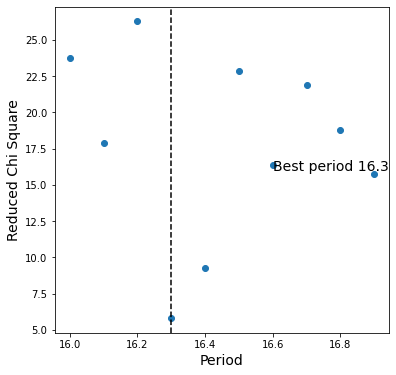

In [7]:
###### Calculating chi square by comparing with gaussian distribution around 0.5 and width of around 0.1 ####

best_period = []
for j in range(1):
    ref_mjd = 58369.40
    ch = []
    per = []
    period = np.arange(16.0,17.0,0.1)
    for pe in period:
        p = fold_data(mjd_all, pe)
        c, exp = get_chisq(p)
        per.append(pe)
        ch.append(c[0])

    per = np.array(per)
    ch = np.array(ch)

    ind = np.argmin(ch)

    print("The best period is", per[ind])
    best_period.append(per[ind])

    plt.figure(figsize=(6,6))
    plt.scatter(per, ch)
    plt.ylabel("Reduced Chi Square", fontsize=14)
    plt.xlabel("Period", fontsize=14)
    plt.axvline(per[ind], c='k', linestyle='--')
    plt.text(16.6, 16, "Best period {}".format(per[ind].round(3)), fontsize=14)
    plt.show()
    gc.collect()

In [8]:
best_period = np.array(best_period)
print("The best period is {} +/- {} days".format(np.mean(best_period), np.std(best_period)))

The best period is 16.300000000000004 +/- 0.0 days


0.5061494213781079 0.06554436961388396 16.3279999999976 0.006149421378107922
Folding around period 16.3279999999976
The best period is 16.3279999999976


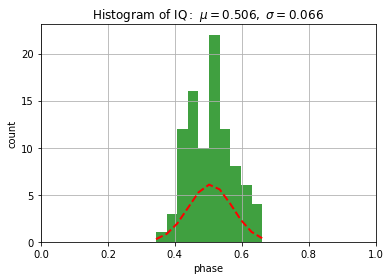

In [9]:
##### Minimizing the spread (sigma) around peak activity ########

from scipy.stats import norm
import matplotlib.mlab as mlab

ref_mjd = 58369.40#np.min(mjd_all)
period = np.arange(12.0,20.0,0.001)

mus = []
sigmas = []
diffs = []

for pe in period:
    phase = fold_data(mjd_all,pe)
    #(mu, sigma) = norm.fit(phase)
    x = norm.fit(phase)
    diff = abs(x[0]-0.5)
    mus.append(x[0])
    sigmas.append(x[1])
    diffs.append(diff)
    
mus = np.array(mus)
diffs = np.array(diffs)
sigmas = np.array(sigmas)

ind = np.argmin(sigmas) 

print(mus[ind], sigmas[ind], period[ind], diffs[ind])

print("Folding around period", period[ind])

phase = fold_data(mjd_all,period[ind])
    

#the histogram of the data
n, bins, patches = plt.hist(phase, 10, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = stats.norm.pdf( bins, mus[ind], sigmas[ind])
l = plt.plot(bins, y, 'r--', linewidth=2)

print("The best period is", period[ind])

#plot
plt.xlabel('phase')
plt.ylabel('count')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mus[ind], sigmas[ind]))
plt.grid(True)
plt.xlim(0,1)

plt.show()



  1%|▏         | 58/4000 [00:00<00:06, 579.72it/s]

Maximum difference between arrival times 1192.72766527778


100%|██████████| 4000/4000 [00:05<00:00, 748.53it/s]


Max reduced chi square value is 9729.112876511974 at period of 16.335999999998705
The error on period with equation 1 is  is 0.07122095216950428


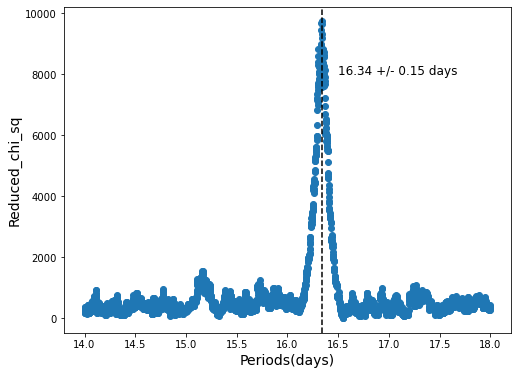

In [10]:
##### Running PR3 algorithm #####

#### Getting the range of periods to search #####
bursts = mjd_all_rem
obs_mjds = exp_timestamp
obs_durations = exp_dur
pmin = 14
pmax = 18
nbins=8

active_d = 5.2

max_diff = bursts[-1]-bursts[0]
print("Maximum difference between arrival times", max_diff)



try:
    assert len(obs_mjds) == len(obs_durations)
except AssertionError as err:
    print("Number of start MJDs and durations should be same.")

periods = np.arange(pmin,pmax,0.001)

chi_sqrs = []
for period in tqdm.tqdm(periods):
    chi_sqrs.append(calc_chi_sq(obs_mjds, obs_durations, bursts, period))#, pdev, nbins=nbins))

chi_sqrs = np.array(chi_sqrs)
nan_mask = (np.isnan(chi_sqrs)) | (np.isinf(chi_sqrs))
red_chi_sqrs = chi_sqrs[~nan_mask]/(nbins-1)
periods = periods[~nan_mask]

arg = np.argmax(red_chi_sqrs)
print(f'Max reduced chi square value is {red_chi_sqrs[arg]} at period of {periods[arg]}')
error_period = (periods[arg]*active_d)/max_diff #### equation 1
print("The error on period with equation 1 is  is", error_period)

p_guess = [1000 ,10000, 16.33, 0.1]

par, cov = curve_fit(gauss, periods, red_chi_sqrs, p0=p_guess)
error_p = 2.355 * par[3]
#print(red_chi_sqrs, periods)

plt.figure(figsize=(8,6))
plt.scatter(periods, red_chi_sqrs)
plt.xlabel("Periods(days)", fontsize=14)
plt.ylabel("Reduced_chi_sq", fontsize=14)
#plt.plot(periods, gauss(periods, par[0], par[1], par[2], par[3]), color='r')
plt.axvline(periods[arg], linestyle='--', color='k')
#plt.text(pmax-1.5, 8000, "{} +/- {} days".format(periods[arg].round(2), error_p.round(2)), fontsize=12)
plt.text(pmax-1.5, 8000, "{} +/- {} days".format(periods[arg].round(2), error_p.round(2)), fontsize=12)
oname = "Final_plots/Periods.pdf"
plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.show()


  4%|▎         | 142/4000 [00:00<00:02, 1416.02it/s]

Maximum difference between arrival times 504.6194927083343


100%|██████████| 4000/4000 [00:02<00:00, 1922.07it/s]


Max reduced chi square value is 6349.1109102043465 at period of 16.39999999999867
The error on period with equation 1 is  is 0.16899862417578898


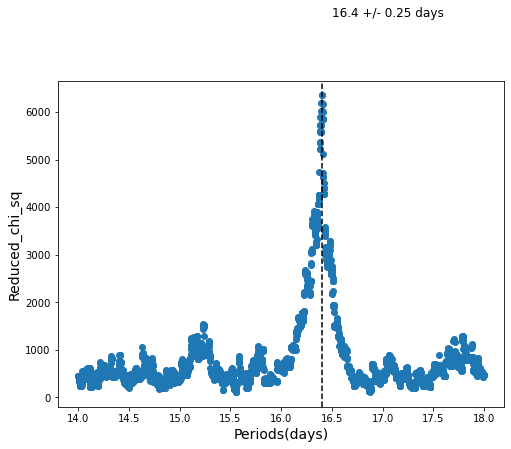

In [11]:
###### Separting MJDs into two and calculating periods ######

cut_off = 58883 ### Last date published in periodicity paper ######
bursts = mjd_all_rem
obs_mjds = exp_timestamp
obs_durations = exp_dur

bursts_before = bursts[bursts<=58883]
obs_mjds_before = obs_mjds[obs_mjds<=58883]

index = np.argmax(obs_mjds>58883)

obs_durations_before = obs_durations[:index]

pmin = 14
pmax = 18
nbins=8

active_d = 5.2

max_diff = bursts_before[-1]-bursts_before[0]
print("Maximum difference between arrival times", max_diff)



try:
    assert len(obs_mjds_before) == len(obs_durations_before)
except AssertionError as err:
    print("Number of start MJDs and durations should be same.")

periods = np.arange(pmin,pmax,0.001)

chi_sqrs = []
for period in tqdm.tqdm(periods):
    chi_sqrs.append(calc_chi_sq(obs_mjds_before, obs_durations_before, bursts_before, period))#, pdev, nbins=nbins))

chi_sqrs = np.array(chi_sqrs)
nan_mask = (np.isnan(chi_sqrs)) | (np.isinf(chi_sqrs))
red_chi_sqrs = chi_sqrs[~nan_mask]/(nbins-1)
periods = periods[~nan_mask]

arg = np.argmax(red_chi_sqrs)
print(f'Max reduced chi square value is {red_chi_sqrs[arg]} at period of {periods[arg]}')
error_period = (periods[arg]*active_d)/max_diff #### equation 1
print("The error on period with equation 1 is  is", error_period)

p_guess = [1000 ,10000, 16.33, 0.1]

par, cov = curve_fit(gauss, periods, red_chi_sqrs, p0=p_guess)
error_p = 2.355 * par[3]
#print(red_chi_sqrs, periods)

plt.figure(figsize=(8,6))
plt.scatter(periods, red_chi_sqrs)
plt.xlabel("Periods(days)", fontsize=14)
plt.ylabel("Reduced_chi_sq", fontsize=14)
#plt.plot(periods, gauss(periods, par[0], par[1], par[2], par[3]), color='r')
plt.axvline(periods[arg], linestyle='--', color='k')
#plt.text(pmax-1.5, 8000, "{} +/- {} days".format(periods[arg].round(2), error_p.round(2)), fontsize=12)
plt.text(pmax-1.5, 8000, "{} +/- {} days".format(periods[arg].round(2), error_p.round(2)), fontsize=12)
oname = "Final_plots/Periods.pdf"
#plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.show()





  3%|▎         | 111/4000 [00:00<00:03, 1106.55it/s]

Maximum difference between arrival times 687.1150281250011


100%|██████████| 4000/4000 [00:03<00:00, 1140.57it/s]


Max reduced chi square value is 6887.665487717969 at period of 16.336999999998703
The error on period with equation 1 is  is 0.12363635857566861


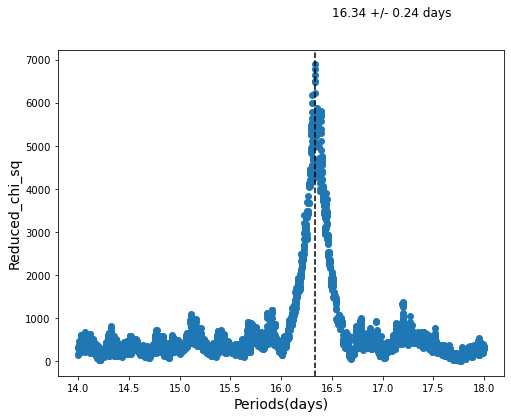

In [12]:
cut_off = 58883 ### Last date published in periodicity paper ######
bursts = mjd_all_rem
obs_mjds = exp_timestamp
obs_durations = exp_dur

bursts_after = bursts[bursts>58883]
obs_mjds_after = obs_mjds[obs_mjds>58883]

index = np.argmax(obs_mjds>58883)

obs_durations_after = obs_durations[index:]

pmin = 14
pmax = 18
nbins=8

active_d = 5.2

max_diff = bursts_after[-1]-bursts_after[0]
print("Maximum difference between arrival times", max_diff)



try:
    assert len(obs_mjds_after) == len(obs_durations_after)
except AssertionError as err:
    print("Number of start MJDs and durations should be same.")

periods = np.arange(pmin,pmax,0.001)

chi_sqrs = []
for period in tqdm.tqdm(periods):
    chi_sqrs.append(calc_chi_sq(obs_mjds_after, obs_durations_after, bursts_after, period))#, pdev, nbins=nbins))

chi_sqrs = np.array(chi_sqrs)
nan_mask = (np.isnan(chi_sqrs)) | (np.isinf(chi_sqrs))
red_chi_sqrs = chi_sqrs[~nan_mask]/(nbins-1)
periods = periods[~nan_mask]

arg = np.argmax(red_chi_sqrs)
print(f'Max reduced chi square value is {red_chi_sqrs[arg]} at period of {periods[arg]}')
error_period = (periods[arg]*active_d)/max_diff #### equation 1
print("The error on period with equation 1 is  is", error_period)

p_guess = [1000 ,10000, 16.33, 0.1]

par, cov = curve_fit(gauss, periods, red_chi_sqrs, p0=p_guess)
error_p = 2.355 * par[3]
#print(red_chi_sqrs, periods)

plt.figure(figsize=(8,6))
plt.scatter(periods, red_chi_sqrs)
plt.xlabel("Periods(days)", fontsize=14)
plt.ylabel("Reduced_chi_sq", fontsize=14)
#plt.plot(periods, gauss(periods, par[0], par[1], par[2], par[3]), color='r')
plt.axvline(periods[arg], linestyle='--', color='k')
#plt.text(pmax-1.5, 8000, "{} +/- {} days".format(periods[arg].round(2), error_p.round(2)), fontsize=12)
plt.text(pmax-1.5, 8000, "{} +/- {} days".format(periods[arg].round(2), error_p.round(2)), fontsize=12)
oname = "Final_plots/Periods.pdf"
#plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.show()

We can see a change upto 0.2 days let's say, time difference between our first and last burst is around 1200, so to see a change of 0.2 in 1200 days is 2e-4 day day ^-1

In [12]:
#### Running without changing nbins ####
import numpy as np
import matplotlib.pyplot as plt
import tqdm


pmin = 16
pmax = 16.6

nruns = 200

# define periods and p_devs
periods = np.linspace(pmin, pmax, nruns)
p_devs = np.linspace(-1e-3, 1e-3, nruns)
p_devs = np.concatenate((p_devs[p_devs<0], [0], p_devs[p_devs>0]))


# calculate chi_sqrs for each combination of period and pdev
chi_sqrs = np.zeros((len(periods), len(p_devs)))

for i, period in enumerate(tqdm.tqdm(periods)):
    for j, pdev in enumerate(tqdm.tqdm(p_devs)):
        chi_sqrs[i, j] = calc_chi_sq(obs_mjds, obs_durations, bursts, period, pdev)
max_idx = np.unravel_index(np.argmax(chi_sqrs, axis=None), chi_sqrs.shape)
i, j = max_idx[0], max_idx[1]
print(periods[i], p_devs[j])




 31%|███       | 62/201 [00:00<00:00, 612.91it/s]


100%|██████████| 201/201 [00:00<00:00, 601.46it/s]


  0%|          | 0/201 [00:00<?, ?it/s]


100%|██████████| 200/200 [01:07<00:00,  2.98it/s]

16.37386934673367 -7.537688442211057e-05


In [13]:
### Running changing nbins ###
import numpy as np
import matplotlib.pyplot as plt
import tqdm


pmin = 14
pmax = 18

nruns = 100

# define periods and p_devs
periods = np.linspace(pmin, pmax, nruns)
p_devs = np.linspace(-8e-4, 8e-4, nruns)
p_devs = np.concatenate((p_devs[p_devs<0], [0], p_devs[p_devs>0]))
nbins = np.arange(2,96,1)
print(p_devs,nbins)

the_nbins = []

# calculate chi_sqrs for each combination of period and pdev
chi_sqrs = np.zeros((len(periods), len(p_devs)))
for nbin in nbins:
    the_nbins.append(nbin)
    print("Running for nbin", nbin)
    for i, period in enumerate(tqdm.tqdm(periods)):
        for j, pdev in enumerate(tqdm.tqdm(p_devs)):
            chi_sqrs[i, j] = calc_chi_sq(obs_mjds, obs_durations, bursts, period, pdev, nbins=nbin)
    max_idx = np.unravel_index(np.argmax(chi_sqrs, axis=None), chi_sqrs.shape)
    i, j = max_idx[0], max_idx[1]
    print(periods[i], p_devs[j])
    the_nbins.append(periods[i])
    the_nbins.append(p_devs[j])
    
the_nbins = np.array(the_nbins)

# normalize chi_sqrs
# chi_sqrs = chi_sqrs / np.max(chi_sqrs)


  0%|          | 0/101 [00:00<?, ?it/s]

[-8.00000000e-04 -7.83838384e-04 -7.67676768e-04 -7.51515152e-04
 -7.35353535e-04 -7.19191919e-04 -7.03030303e-04 -6.86868687e-04
 -6.70707071e-04 -6.54545455e-04 -6.38383838e-04 -6.22222222e-04
 -6.06060606e-04 -5.89898990e-04 -5.73737374e-04 -5.57575758e-04
 -5.41414141e-04 -5.25252525e-04 -5.09090909e-04 -4.92929293e-04
 -4.76767677e-04 -4.60606061e-04 -4.44444444e-04 -4.28282828e-04
 -4.12121212e-04 -3.95959596e-04 -3.79797980e-04 -3.63636364e-04
 -3.47474747e-04 -3.31313131e-04 -3.15151515e-04 -2.98989899e-04
 -2.82828283e-04 -2.66666667e-04 -2.50505051e-04 -2.34343434e-04
 -2.18181818e-04 -2.02020202e-04 -1.85858586e-04 -1.69696970e-04
 -1.53535354e-04 -1.37373737e-04 -1.21212121e-04 -1.05050505e-04
 -8.88888889e-05 -7.27272727e-05 -5.65656566e-05 -4.04040404e-05
 -2.42424242e-05 -8.08080808e-06  0.00000000e+00  8.08080808e-06
  2.42424242e-05  4.04040404e-05  5.65656566e-05  7.27272727e-05
  8.88888889e-05  1.05050505e-04  1.21212121e-04  1.37373737e-04
  1.53535354e-04  1.69696


  0%|          | 0/101 [00:00<?, ?it/s]

16.02020202020202 0.00047676767676767663
Running for nbin 3



  0%|          | 0/101 [00:00<?, ?it/s]

16.343434343434343 -4.0404040404040426e-05
Running for nbin 4



  0%|          | 0/101 [00:00<?, ?it/s]

16.424242424242426 -0.00012121212121212128
Running for nbin 5



  0%|          | 0/101 [00:00<?, ?it/s]

16.343434343434343 -2.4242424242424342e-05
Running for nbin 6



  0%|          | 0/101 [00:00<?, ?it/s]

16.424242424242426 -0.00013737373737373747
Running for nbin 7



  0%|          | 0/101 [00:00<?, ?it/s]

16.303030303030305 4.040404040404032e-05
Running for nbin 8



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -7.272727272727281e-05
Running for nbin 9



  0%|          | 0/101 [00:00<?, ?it/s]

16.343434343434343 -4.0404040404040426e-05
Running for nbin 10



  0%|          | 0/101 [00:00<?, ?it/s]

16.343434343434343 0.0
Running for nbin 11



  0%|          | 0/101 [00:00<?, ?it/s]

16.343434343434343 -8.08080808080815e-06
Running for nbin 12



  0%|          | 0/101 [00:00<?, ?it/s]

16.343434343434343 -4.0404040404040426e-05
Running for nbin 13



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -0.00010505050505050509
Running for nbin 14



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -7.272727272727281e-05
Running for nbin 15



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -0.00010505050505050509
Running for nbin 16



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -7.272727272727281e-05
Running for nbin 17



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -5.656565656565662e-05
Running for nbin 18



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -8.888888888888889e-05
Running for nbin 19



  0%|          | 0/101 [00:00<?, ?it/s]

16.343434343434343 -2.4242424242424342e-05
Running for nbin 20



  0%|          | 0/101 [00:00<?, ?it/s]

16.383838383838384 -0.00010505050505050509
Running for nbin 21



  0%|          | 0/101 [00:00<?, ?it/s]<ipython-input-2-7cdf68695265>:119: RuntimeWarning: invalid value encountered in true_divide
  return (((N - E) ** 2) / E).sum()

  0%|          | 0/101 [00:00<?, ?it/s]

16.949494949494948 8.080808080808042e-06
Running for nbin 22



  0%|          | 0/101 [00:00<?, ?it/s]

16.949494949494948 8.080808080808042e-06
Running for nbin 23



  0%|          | 0/101 [00:00<?, ?it/s]

16.949494949494948 8.080808080808042e-06
Running for nbin 24



  0%|          | 0/101 [00:00<?, ?it/s]

16.949494949494948 8.080808080808042e-06
Running for nbin 25



  0%|          | 0/101 [00:00<?, ?it/s]

16.949494949494948 0.0
Running for nbin 26



  0%|          | 0/101 [00:00<?, ?it/s]

16.949494949494948 0.0
Running for nbin 27



  0%|          | 0/101 [00:00<?, ?it/s]<ipython-input-2-7cdf68695265>:119: RuntimeWarning: divide by zero encountered in true_divide
  return (((N - E) ** 2) / E).sum()

  0%|          | 0/101 [00:00<?, ?it/s]

15.93939393939394 2.4242424242424234e-05
Running for nbin 28



  0%|          | 0/101 [00:00<?, ?it/s]

15.93939393939394 2.4242424242424234e-05
Running for nbin 29



  0%|          | 0/101 [00:00<?, ?it/s]

15.93939393939394 2.4242424242424234e-05
Running for nbin 30



  0%|          | 0/101 [00:00<?, ?it/s]

15.93939393939394 2.4242424242424234e-05
Running for nbin 31



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 32



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 33



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 34



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 35



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 36



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 37



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 38



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 39



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 40



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 41



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 42



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 43



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 44



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 45



  0%|          | 0/101 [00:00<?, ?it/s]

15.93939393939394 2.4242424242424234e-05
Running for nbin 46



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 47



  0%|          | 0/101 [00:00<?, ?it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 48



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 49



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 50



  0%|          | 0/101 [00:00<?, ?it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 51



  1%|          | 1/100 [00:00<00:19,  5.00it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 52



  0%|          | 0/101 [00:00<?, ?it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 53



100%|██████████| 101/101 [00:00<00:00, 504.89it/s][A

14.929292929292929 4.040404040404032e-05
Running for nbin 54



  0%|          | 0/101 [00:00<?, ?it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 55



100%|██████████| 101/101 [00:00<00:00, 505.79it/s][A

14.929292929292929 4.040404040404032e-05
Running for nbin 56



 50%|████▉     | 50/101 [00:00<00:00, 499.01it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 57



 50%|████▉     | 50/101 [00:00<00:00, 497.19it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 58



 50%|████▉     | 50/101 [00:00<00:00, 494.11it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 59



100%|██████████| 101/101 [00:00<00:00, 492.87it/s]


 50%|████▉     | 50/101 [00:00<00:00, 492.74it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 60



 95%|█████████▌| 95/100 [00:19<00:01,  4.81it/s]


 50%|████▉     | 50/101 [00:00<00:00, 492.25it/s]

14.969696969696969 -2.4242424242424342e-05
Running for nbin 61



 49%|████▊     | 49/101 [00:00<00:00, 489.68it/s]


 50%|████▉     | 50/101 [00:00<00:00, 491.91it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 62



  0%|          | 0/101 [00:00<?, ?it/s]


 50%|████▉     | 50/101 [00:00<00:00, 494.63it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 63



 50%|████▉     | 50/101 [00:00<00:00, 493.15it/s]


 50%|████▉     | 50/101 [00:00<00:00, 494.57it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 64



100%|██████████| 101/101 [00:00<00:00, 485.27it/s]


 49%|████▊     | 49/101 [00:00<00:00, 485.55it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 65



 86%|████████▌ | 86/100 [00:17<00:02,  4.80it/s]


 49%|████▊     | 49/101 [00:00<00:00, 485.58it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 66



100%|██████████| 101/101 [00:00<00:00, 488.44it/s][A


 49%|████▊     | 49/101 [00:00<00:00, 483.39it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 67



100%|██████████| 101/101 [00:00<00:00, 483.63it/s][A


 49%|████▊     | 49/101 [00:00<00:00, 482.19it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 68



 49%|████▊     | 49/101 [00:00<00:00, 486.14it/s]


 48%|████▊     | 48/101 [00:00<00:00, 479.76it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 69



  0%|          | 0/101 [00:00<?, ?it/s]


 48%|████▊     | 48/101 [00:00<00:00, 478.75it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 70



 83%|████████▎ | 83/100 [00:17<00:03,  4.74it/s]


 48%|████▊     | 48/101 [00:00<00:00, 478.06it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 71



  0%|          | 0/101 [00:00<?, ?it/s]


 48%|████▊     | 48/101 [00:00<00:00, 472.61it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 72



 83%|████████▎ | 83/100 [00:17<00:03,  4.71it/s]


 48%|████▊     | 48/101 [00:00<00:00, 478.79it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 73



 83%|████████▎ | 83/100 [00:17<00:03,  4.70it/s]


 48%|████▊     | 48/101 [00:00<00:00, 475.90it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 74



 83%|████████▎ | 83/100 [00:17<00:03,  4.67it/s]


 48%|████▊     | 48/101 [00:00<00:00, 474.16it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 75



 83%|████████▎ | 83/100 [00:17<00:03,  4.68it/s]


 48%|████▊     | 48/101 [00:00<00:00, 477.43it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 76



 83%|████████▎ | 83/100 [00:17<00:03,  4.65it/s]


 47%|████▋     | 47/101 [00:00<00:00, 469.03it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 77



 83%|████████▎ | 83/100 [00:17<00:03,  4.66it/s]


 48%|████▊     | 48/101 [00:00<00:00, 474.25it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 78



 83%|████████▎ | 83/100 [00:17<00:03,  4.63it/s]


 47%|████▋     | 47/101 [00:00<00:00, 463.33it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 79



 83%|████████▎ | 83/100 [00:17<00:03,  4.61it/s]


 47%|████▋     | 47/101 [00:00<00:00, 463.97it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 80



 83%|████████▎ | 83/100 [00:17<00:03,  4.62it/s]


 47%|████▋     | 47/101 [00:00<00:00, 465.20it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 81



 83%|████████▎ | 83/100 [00:17<00:03,  4.59it/s]


 47%|████▋     | 47/101 [00:00<00:00, 460.98it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 82



 83%|████████▎ | 83/100 [00:18<00:03,  4.56it/s]


 47%|████▋     | 47/101 [00:00<00:00, 468.72it/s]

14.929292929292929 4.040404040404032e-05
Running for nbin 83



 83%|████████▎ | 83/100 [00:18<00:03,  4.58it/s]


 46%|████▌     | 46/101 [00:00<00:00, 458.96it/s]

14.16161616161616 0.0
Running for nbin 84



 83%|████████▎ | 83/100 [00:18<00:03,  4.56it/s]


 46%|████▌     | 46/101 [00:00<00:00, 457.94it/s]

14.444444444444445 2.4242424242424234e-05
Running for nbin 85



 83%|████████▎ | 83/100 [00:18<00:03,  4.54it/s]


 46%|████▌     | 46/101 [00:00<00:00, 457.61it/s]

14.16161616161616 0.0
Running for nbin 86



 83%|████████▎ | 83/100 [00:18<00:03,  4.52it/s]


 46%|████▌     | 46/101 [00:00<00:00, 456.24it/s]

14.16161616161616 0.0
Running for nbin 87



 83%|████████▎ | 83/100 [00:18<00:03,  4.53it/s]


 46%|████▌     | 46/101 [00:00<00:00, 453.26it/s]

14.16161616161616 0.0
Running for nbin 88



 83%|████████▎ | 83/100 [00:18<00:03,  4.51it/s]


 46%|████▌     | 46/101 [00:00<00:00, 454.31it/s]

14.16161616161616 0.0
Running for nbin 89



 83%|████████▎ | 83/100 [00:18<00:03,  4.51it/s]


 46%|████▌     | 46/101 [00:00<00:00, 450.87it/s]

14.16161616161616 0.0
Running for nbin 90



 83%|████████▎ | 83/100 [00:18<00:03,  4.47it/s]


 45%|████▍     | 45/101 [00:00<00:00, 448.79it/s]

14.16161616161616 0.0
Running for nbin 91



 83%|████████▎ | 83/100 [00:18<00:03,  4.47it/s]


 45%|████▍     | 45/101 [00:00<00:00, 447.33it/s]

14.16161616161616 0.0
Running for nbin 92



 83%|████████▎ | 83/100 [00:18<00:03,  4.44it/s]


 46%|████▌     | 46/101 [00:00<00:00, 454.95it/s]

14.16161616161616 0.0
Running for nbin 93



 83%|████████▎ | 83/100 [00:18<00:03,  4.44it/s]


 45%|████▍     | 45/101 [00:00<00:00, 444.75it/s]

14.16161616161616 0.0
Running for nbin 94



 83%|████████▎ | 83/100 [00:18<00:03,  4.43it/s]


 45%|████▍     | 45/101 [00:00<00:00, 443.70it/s]

14.0 -5.656565656565662e-05
Running for nbin 95



 83%|████████▎ | 83/100 [00:18<00:03,  4.42it/s]


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]

14.0 -0.00012121212121212128


In [29]:
print(the_nbins)

[]


16.37386934673367 -7.537688442211057e-05
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean              y_mean         ... y_stddev theta 
    ----------------- ----------------- ---------------------- ... -------- ------
    72517.18786470973 16.37386934673367 -7.537688442211057e-05 ...    1e-05 -0.001
(200, 201)
(200,)
(201,)
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean      ...         theta         
    ----------------- ----------------- ... ----------------------
    50344.10611040178 16.34027093398242 ... -0.0016176704762226359


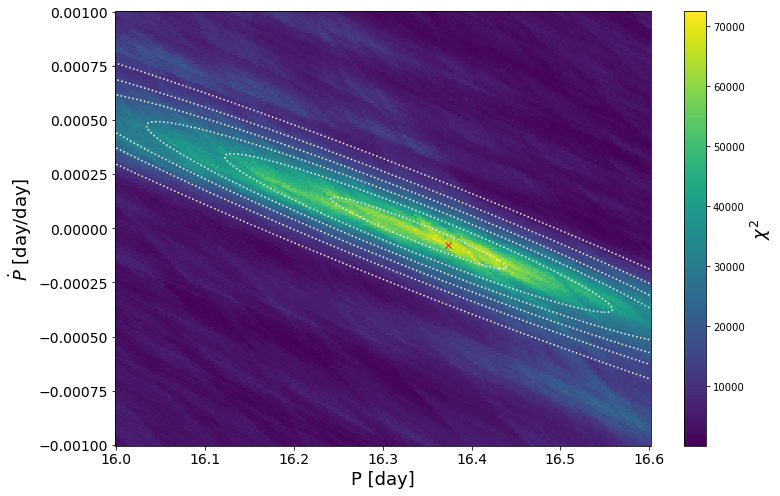

In [16]:
#### Plotting #####

# plot chi_sqrs as a heatmap
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.pcolormesh(periods, p_devs, chi_sqrs.T, cmap='viridis', shading='nearest')

# add text annotations for chi_sqr values
# for i in range(len(periods)):
#     for j in range(len(p_devs)):
#         ax.text(periods[i], p_devs[j], f'{chi_sqrs[i,j]:.2f}', ha='center', va='center', color='black', fontsize=8)

# add a red dot at the maximum chi_sqr point
max_idx = np.unravel_index(np.argmax(chi_sqrs, axis=None), chi_sqrs.shape)
i, j = max_idx[0], max_idx[1]
ax.plot(periods[i], p_devs[j], 'rx')

print(periods[i], p_devs[j])

ax.set_xlabel(r'P [day]', fontsize=18)
ax.set_ylabel(r'$\dot{P}$ [day/day]', fontsize=18)
#ax.set_title('Chi_sqrs at each combination of Period and Pdev', fontsize=16)

# set label for colorbar
cbar = fig.colorbar(im, ax=ax)
#cbar.set_label('Normalized Chi square', fontsize=14)
cbar.set_label(r'$\chi^{2}$', fontsize=18)

# increase font size of all ticks
ax.tick_params(axis='both', which='major', labelsize=14)

#Fitting 2-D gaussian
fit_init = models.Gaussian2D(amplitude=np.max(chi_sqrs.T), x_mean=periods[i], y_mean=p_devs[j], x_stddev=0.007, y_stddev=0.00001,theta=-0.001)
print(fit_init)
fit_fitter = fitting.LevMarLSQFitter()
print(chi_sqrs.shape)
print(periods.shape)
print(p_devs.shape)

x, y = np.meshgrid(periods, p_devs)
fit_result = fit_fitter(fit_init, x.ravel(), y.ravel(), chi_sqrs.T.ravel())
np.set_printoptions(threshold=sys.maxsize)
print(fit_result)

# plot the fitted 2D Gaussian
x, y = np.meshgrid(periods, p_devs)
fit_z = fit_result(x, y)
ax.contour(x, y, fit_z, levels=7, colors='w', linestyles='dotted')

oname = "Final_plots/P_pdot_{}_gauss_fit_2.pdf".format(nruns)
plt.savefig(oname, bbox_inches='tight', dpi=300)
plt.show()

In [23]:
import gc
gc.collect()

899

In [14]:
attrs = vars(fit_result)
print(attrs)

{'_inputs': ('x', 'y'), '_outputs': ('z',), '_name': None, 'amplitude': Parameter('amplitude', value=50344.10611040178), 'x_mean': Parameter('x_mean', value=16.34027093398242), 'y_mean': Parameter('y_mean', value=-2.1100997487783992e-05), 'x_stddev': Parameter('x_stddev', value=0.3217857329838651, bounds=(1.1754943508222875e-38, None)), 'y_stddev': Parameter('y_stddev', value=0.00014572200636841438, bounds=(1.1754943508222875e-38, None)), 'theta': Parameter('theta', value=-0.0016176704762226359), '_mconstraints': {'eqcons': [], 'ineqcons': []}, '_model_set_axis': False, '_param_metrics': defaultdict(<class 'dict'>, {'amplitude': {'slice': slice(0, 1, None), 'shape': (), 'size': 1}, 'x_mean': {'slice': slice(1, 2, None), 'shape': (), 'size': 1}, 'y_mean': {'slice': slice(2, 3, None), 'shape': (), 'size': 1}, 'x_stddev': {'slice': slice(3, 4, None), 'shape': (), 'size': 1}, 'y_stddev': {'slice': slice(4, 5, None), 'shape': (), 'size': 1}, 'theta': {'slice': slice(5, 6, None), 'shape': ()

If we assume pdot is zero the period is 16.34 \pm 0.07. If we allow a pdot term in our phase calculation, we can see the variation. We took pdot values ranging from -0.001 to +0.001. We did the chi_sq test as described in PR3 and we find the best pdot value of -0.00002 \pm 0.0001. We put a 90% upperlimit on pdot to be 2.146 times the std_dev (since this is a 2-D gaussian) we get 0.0002, we put a limit of 0.0002 day day^-1

In [15]:
np.sqrt(-2*np.log(1-0.99))

3.0348542587702925

In [4]:
(16.34*5.5)/(1192)**2

6.325024773658844e-07

In [ ]:
#### Using meshgrid to lower runtime ######

import numpy as np
import matplotlib.pyplot as plt
import tqdm


pmin = 14
pmax = 18

nruns = 10

# define periods and p_devs
periods = np.linspace(pmin, pmax, nruns)
p_devs = np.linspace(-8e-4, 8e-4, nruns)
p_devs = np.concatenate((p_devs[p_devs<0], [0], p_devs[p_devs>0]))
nbins = np.arange(2,30,1)

X, Y = np.meshgrid(periods, p_devs)

phase = fold_data(bursts, X, 58369.40, Y)
print(phase)

# the_nbins = []

# # calculate chi_sqrs for each combination of period and pdev
# chi_sqrs = np.zeros((len(periods), len(p_devs), len(nbins)))


# chi_sqrs = calc_chi_sq(obs_mjds, obs_durations,  bursts, X, Y, Z)
# print(chi_sqrs)
# for nbin in nbins:
#     the_nbins.append(nbin)
#     print("Running for nbin", nbin)
#     for i, period in enumerate(tqdm.tqdm(periods)):
#         for j, pdev in enumerate(tqdm.tqdm(p_devs)):
#             chi_sqrs[i, j] = calc_chi_sq(obs_mjds, obs_durations, bursts, period, pdev, nbins=nbin)
#     max_idx = np.unravel_index(np.argmax(chi_sqrs, axis=None), chi_sqrs.shape)
#     i, j = max_idx[0], max_idx[1]
#     print(periods[i], p_devs[j])
#     the_nbins.append(periods[i])
#     the_nbins.append(p_devs[j])
    
# the_nbins = np.array(the_nbins)

In [ ]:
import numpy as np

per = 0.68

S